# library imports

In [1485]:
import pandas as pd 
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kruskal
from scikit_posthocs import posthoc_dunn
import itertools
import seaborn as sns
import optuna
from optuna.pruners import MedianPruner
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold

# Load our data

In [1486]:
ratings = {'Rating': [], 'Date': [], 'Resort': []}
n_comment = {}
ratings = pd.DataFrame(ratings)
for file in os.listdir('comments/'):
    filepath = os.path.join('comments/', file)
    df = pd.read_csv(filepath)
    date = df['Date']
    rating = df['Rating']
    resort = file.split('.')
    if len(resort)==2: resort = resort[0]
    else: 
        resort = resort[0]+'.'+resort[1]
    df_tmp = pd.DataFrame({
        'Rating': rating,
        'Date': date,
        'Resort': [resort]*df.shape[0]
    })
    ratings =  pd.concat([ratings, df_tmp])
    n_comment[resort] = df.shape[0]

In [1487]:
ratings

,Rating,Date,Resort
0,4.0,2017-04-22 03:53:09,Charlotte
1,5.0,2017-06-11 03:54:51,Charlotte
2,5.0,2017-10-18 07:23:51,Charlotte
3,4.0,2017-12-04 09:57:32,Charlotte
4,4.0,2017-12-08 06:26:21,Charlotte
...,...,...,...
2635,2.0,2025-08-27 11:34:04,Thredbo
2636,4.0,2025-08-27 12:16:21,Thredbo
2637,5.0,2025-08-29 04:46:27,Thredbo
2638,5.0,2025-08-29 12:18:15,Thredbo


In [1488]:
ratings = pd.DataFrame(ratings)
ratings.head()

,Rating,Date,Resort
0,4.0,2017-04-22 03:53:09,Charlotte
1,5.0,2017-06-11 03:54:51,Charlotte
2,5.0,2017-10-18 07:23:51,Charlotte
3,4.0,2017-12-04 09:57:32,Charlotte
4,4.0,2017-12-08 06:26:21,Charlotte


In [1489]:
ratings['Resort'].unique()

array(['Charlotte', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller',
       'Mt. Hotham', 'Mt. Stirling', 'Perisher', 'Selwyn', 'Thredbo'],
      dtype=object)

In [1490]:
ratings['Resort']=ratings['Resort'].map(lambda x: 'Charlotte Pass' if x=='Charlotte' else x)

# Data transformations

In [1491]:
# These are artificial dates for the ratings
# If a rating is made at week1 in a year, it is marked to be on the first date of the week
def compute_custom_week(date):
    date = datetime.strptime(date,"%Y-%m-%d %H:%M:%S")
    week1_start = pd.to_datetime(f"{date.year}-06-09")
    days_diff = (date - week1_start).days

    week_num = (days_diff // 7) + 1

    return 'week'+str(week_num) if week_num >= 1 and week_num<=15 else None  

In [1492]:
compute_custom_week(ratings['Date'].values[0])

In [1493]:
ratings['Week'] = ratings['Date'].apply(lambda x:compute_custom_week(x))

In [1494]:
ratings = ratings[~ratings['Week'].isnull()]

In [1495]:
ratings

,Rating,Date,Resort,Week
1,5.0,2017-06-11 03:54:51,Charlotte Pass,week1
19,1.0,2018-08-19 05:10:19,Charlotte Pass,week11
20,1.0,2018-08-26 00:55:01,Charlotte Pass,week12
35,5.0,2019-06-09 11:49:33,Charlotte Pass,week1
36,5.0,2019-06-20 11:50:03,Charlotte Pass,week2
...,...,...,...,...
2635,2.0,2025-08-27 11:34:04,Thredbo,week12
2636,4.0,2025-08-27 12:16:21,Thredbo,week12
2637,5.0,2025-08-29 04:46:27,Thredbo,week12
2638,5.0,2025-08-29 12:18:15,Thredbo,week12


In [1496]:
# Make Year as a feature for the ease of data processing later
ratings['Year'] = ratings['Date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)

In [1497]:
ratings = ratings.groupby(['Resort','Week', 'Year'])['Rating'].mean()

In [1498]:
# Generate the dataset
ratings.reset_index().to_csv('ratings.csv')

# More Analysis on the ratings
## Visualization on ratings changement

In [1499]:
ratings = pd.DataFrame(ratings.reset_index())
ratings['week_num'] = ratings['Week'].apply(lambda x: int(x[-1]))
ratings = ratings.sort_values(['Resort', 'week_num', 'Year'])

In [1500]:
ratings.isnull().sum()

Resort      0
Week        0
Year        0
Rating      0
week_num    0
dtype: int64

In [1501]:
ratings

,Resort,Week,Year,Rating,week_num
3,Charlotte Pass,week10,2020,5.000000,0
4,Charlotte Pass,week10,2021,5.000000,0
5,Charlotte Pass,week10,2022,3.500000,0
6,Charlotte Pass,week10,2025,5.000000,0
0,Charlotte Pass,week1,2017,5.000000,1
...,...,...,...,...,...
708,Thredbo,week9,2021,3.800000,9
709,Thredbo,week9,2022,4.692308,9
710,Thredbo,week9,2023,4.625000,9
711,Thredbo,week9,2024,4.600000,9


In [1502]:
ratings.dtypes

Resort       object
Week         object
Year          int64
Rating      float64
week_num      int64
dtype: object

In [1503]:
ratings = ratings[ratings['Year']>2013]

In [1504]:
ratings.head()

,Resort,Week,Year,Rating,week_num
3,Charlotte Pass,week10,2020,5.0,0
4,Charlotte Pass,week10,2021,5.0,0
5,Charlotte Pass,week10,2022,3.5,0
6,Charlotte Pass,week10,2025,5.0,0
0,Charlotte Pass,week1,2017,5.0,1


In [1505]:
ratings['Date'] = pd.to_datetime(ratings['Year'].astype(str) + '-06-09') + pd.to_timedelta((ratings['week_num']) * 7, unit='D')

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\2824894695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['Date'] = pd.to_datetime(ratings['Year'].astype(str) + '-06-09') + pd.to_timedelta((ratings['week_num']) * 7, unit='D')


In [1506]:
ratings.tail()

,Resort,Week,Year,Rating,week_num,Date
708,Thredbo,week9,2021,3.800000,9,2021-08-11
709,Thredbo,week9,2022,4.692308,9,2022-08-11
710,Thredbo,week9,2023,4.625000,9,2023-08-11
711,Thredbo,week9,2024,4.600000,9,2024-08-11
712,Thredbo,week9,2025,4.000000,9,2025-08-11


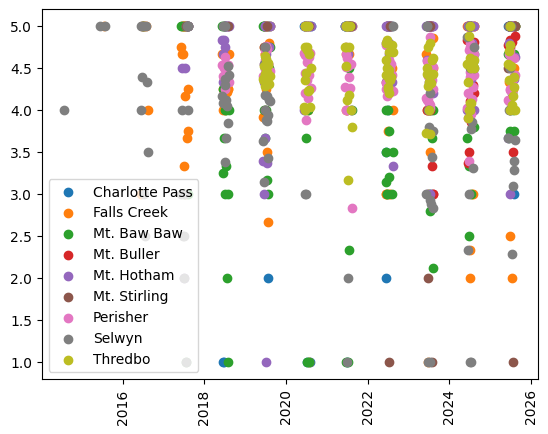

In [1507]:
fig, ax= plt.subplots(1,1)
for x in ratings.Resort.unique():
    data = ratings.loc[ratings['Resort']==x]
    data = data.sort_values('Date')
    data = data.sort_values(['week_num', 'Year'])
    ax.scatter(data['Date'], data['Rating'], label = x)
plt.xticks(rotation=90)
plt.legend()

## Aggregate ratings with visitation dataset

In [1508]:
visit_aus = pd.read_excel('2025 Allianz Datathon Dataset.xlsx', sheet_name='Visitation Data')

In [1509]:
visit_aus = visit_aus.melt(value_vars=['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 	'Mt. Buller',  'Selwyn',
	                       'Thredbo', 'Perisher',  'Charlotte Pass'], id_vars=['Year', 'Week'])

In [1510]:
visit_aus['variable'].unique()

array(['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek',
       'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass'],
      dtype=object)

In [1511]:
visit_aus_mu = visit_aus.groupby(['variable', 'Week', 'Year']).value.mean().reset_index()

In [1512]:
visit_aus_mu[(visit_aus_mu['variable']=='Charlotte Pass') & (visit_aus_mu['Week']==3)]

,variable,Week,Year,value
22,Charlotte Pass,3,2014,230.0
23,Charlotte Pass,3,2015,501.0
24,Charlotte Pass,3,2016,1096.0
25,Charlotte Pass,3,2017,842.0
26,Charlotte Pass,3,2018,1264.0
27,Charlotte Pass,3,2019,992.0
28,Charlotte Pass,3,2020,133.0
29,Charlotte Pass,3,2021,1307.0
30,Charlotte Pass,3,2022,2385.0
31,Charlotte Pass,3,2023,1607.0


In [1513]:
ratings['week_num'] = ratings['week_num']+1
combined_visit_ratings = visit_aus.merge(ratings, left_on=['variable', 'Week', 'Year'], right_on=['Resort', 'week_num', 'Year'])

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\1530316642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['week_num'] = ratings['week_num']+1


In [1514]:
for x in combined_visit_ratings['Resort'].unique():
    data = combined_visit_ratings[combined_visit_ratings['Resort']==x]
    data = data.sort_values(by=['Date'])
    result = pearsonr(data['value'], data['Rating'])
    print(f'Pearson Correlation on n_visits and Ratings at resort {x} has a stats of {round(result.statistic, 3)} with pval of {round(result.pvalue, 3)}')

Pearson Correlation on n_visits and Ratings at resort Mt. Baw Baw has a stats of 0.003 with pval of 0.976
Pearson Correlation on n_visits and Ratings at resort Mt. Stirling has a stats of -0.097 with pval of 0.731
Pearson Correlation on n_visits and Ratings at resort Mt. Hotham has a stats of 0.001 with pval of 0.993
Pearson Correlation on n_visits and Ratings at resort Falls Creek has a stats of 0.019 with pval of 0.856
Pearson Correlation on n_visits and Ratings at resort Mt. Buller has a stats of 0.055 with pval of 0.812
Pearson Correlation on n_visits and Ratings at resort Selwyn has a stats of -0.18 with pval of 0.094
Pearson Correlation on n_visits and Ratings at resort Thredbo has a stats of -0.077 with pval of 0.475
Pearson Correlation on n_visits and Ratings at resort Perisher has a stats of 0.122 with pval of 0.228
Pearson Correlation on n_visits and Ratings at resort Charlotte Pass has a stats of 0.015 with pval of 0.944


In [1515]:
v = visit_aus.groupby('variable')['value'].sum()

In [1516]:
r = ratings.groupby('Resort')['Rating'].mean()

In [1517]:
r

Resort
Charlotte Pass    3.850000
Falls Creek       4.286550
Mt. Baw Baw       3.932335
Mt. Buller        4.409056
Mt. Hotham        4.622528
Mt. Stirling      4.154762
Perisher          4.416697
Selwyn            3.823568
Thredbo           4.450554
Name: Rating, dtype: float64

In [1518]:
list(n_comment.values())

[169, 446, 481, 276, 579, 72, 5000, 828, 2640]

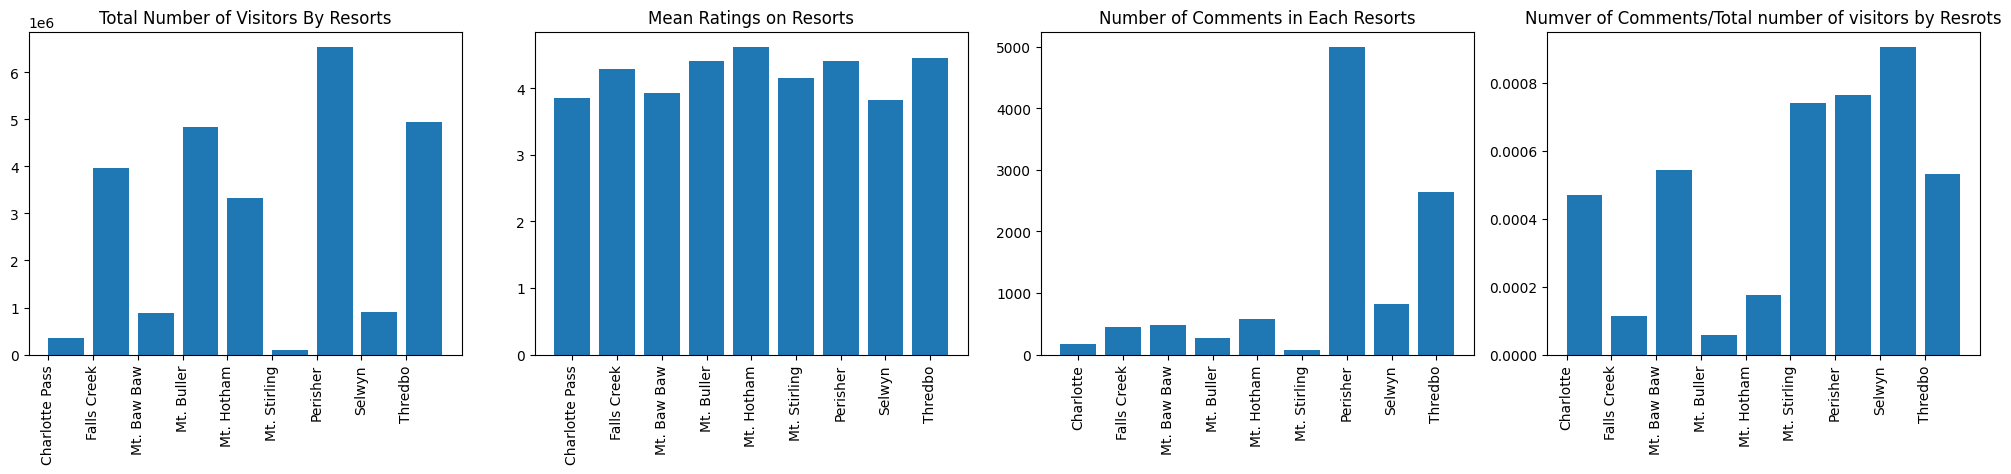

In [1519]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
ax[0].bar(x = v.index, height = v, align='edge')
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Total Number of Visitors By Resorts')
ax[1].bar(x=r.index, height = r)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('Mean Ratings on Resorts')
ax[2].bar(x = list(n_comment.keys()), height = list(n_comment.values()))
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('Number of Comments in Each Resorts')
ax[3].bar(x = list(n_comment.keys()), height = list(n_comment.values())/v, align='edge')
ax[3].tick_params(axis='x', labelrotation=90)
ax[3].set_title('Numver of Comments/Total number of visitors by Resrots')
plt.tight_layout()
plt.show()

In [1520]:
pearsonr(v, r)

PearsonRResult(statistic=0.7786250429899373, pvalue=0.013431407051695257)

In [1521]:
pearsonr(list(n_comment.values()), v)

PearsonRResult(statistic=0.7083797163355615, pvalue=0.03268914318218075)

In [1522]:
pearsonr(list(n_comment.values())/v, r)

PearsonRResult(statistic=-0.5071151083931277, pvalue=0.1634934129747951)

# checking how different our ratings in the fields are

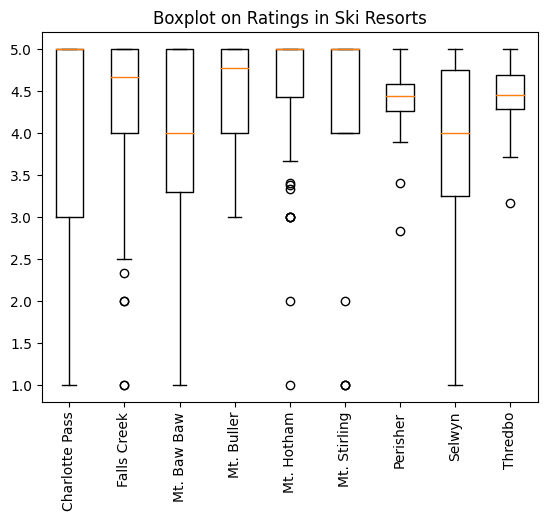

In [1523]:
plt.boxplot(rating_matrix)
plt.xticks(range(1, 10),locs, rotation = 90)
plt.title('Boxplot on Ratings in Ski Resorts')
plt.show()

In [1524]:
rating_matrix = []
locs = ratings.Resort.unique()
for x in locs:
    data = ratings[ratings['Resort']==x]
    data = data.sort_values(by='Date') 
    rating_matrix.append(data['Rating'].values)

kruskal(rating_matrix[0], rating_matrix[1], rating_matrix[2], rating_matrix[3], rating_matrix[4], rating_matrix[5], 
        rating_matrix[6], rating_matrix[7], rating_matrix[8])

KruskalResult(statistic=70.5621494351013, pvalue=3.797693651195761e-12)

In [1525]:
dunn_result = posthoc_dunn(rating_matrix)
rename = {i+1:locs[i] for i in range(9)}
dunn_result = dunn_result.rename(columns=rename, index= rename)
dunn_result

,Charlotte Pass,Falls Creek,Mt. Baw Baw,Mt. Buller,Mt. Hotham,Mt. Stirling,Perisher,Selwyn,Thredbo
Charlotte Pass,1.000000,0.983111,7.657865e-02,0.889005,2.003758e-02,0.285726,0.393973,7.831837e-03,0.652483
Falls Creek,0.983111,1.000000,7.679880e-03,0.877250,5.036484e-04,0.210460,0.186062,6.521556e-05,0.481893
Mt. Baw Baw,0.076579,0.007680,1.000000e+00,0.044299,9.251073e-10,0.005103,0.159994,1.931603e-01,0.051471
Mt. Buller,0.889005,0.877250,4.429899e-02,1.000000,2.534835e-02,0.336059,0.288013,3.359588e-03,0.520508
Mt. Hotham,0.020038,0.000504,9.251073e-10,0.025348,1.000000e+00,0.461713,0.000001,7.822873e-14,0.000032
Mt. Stirling,0.285726,0.210460,5.103060e-03,0.336059,4.617131e-01,1.000000,0.043985,3.549342e-04,0.097546
Perisher,0.393973,0.186062,1.599941e-01,0.288013,1.094126e-06,0.043985,1.000000,5.962842e-03,0.552033
Selwyn,0.007832,0.000065,1.931603e-01,0.003360,7.822873e-14,0.000355,0.005963,1.000000e+00,0.001113
Thredbo,0.652483,0.481893,5.147079e-02,0.520508,3.248293e-05,0.097546,0.552033,1.113024e-03,1.000000


Text(0.5, 1.0, 'Highlighted Significant Difference in Ratings of Ski Resorts compared to each other')

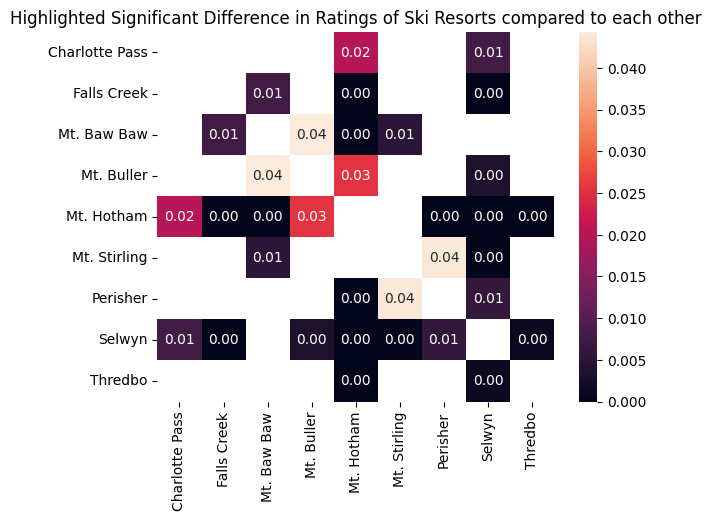

In [1526]:
mask = dunn_result>0.05
sns.heatmap(dunn_result, annot=True, fmt='.2f', mask = mask)
plt.title('Highlighted Significant Difference in Ratings of Ski Resorts compared to each other')

# Check if review is related to fares

In [1527]:
price = pd.read_excel('Price and Distance Data.xlsx')
price.head()

,Unnamed: 0,Mt Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
0,Price (AUD),302,186,942,942,573,733,819,1029,927
1,Distance to CBD (km),177,237,376,386,232,537,548,605,616


In [1528]:
price = price.rename(columns={'Mt Baw Baw': 'Mt. Baw Baw'})

In [1529]:
price

,Unnamed: 0,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
0,Price (AUD),302,186,942,942,573,733,819,1029,927
1,Distance to CBD (km),177,237,376,386,232,537,548,605,616


In [1530]:
locs

array(['Charlotte Pass', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller',
       'Mt. Hotham', 'Mt. Stirling', 'Perisher', 'Selwyn', 'Thredbo'],
      dtype=object)

In [1531]:
prices = [price.loc[0, x] for x in locs]
distance = [price.loc[1, x] for x in locs]

In [1532]:
pearsonr(prices, r)

PearsonRResult(statistic=0.33258598251528604, pvalue=0.38184813328716233)

In [1533]:
pearsonr(distance, r)

PearsonRResult(statistic=-0.06786940133909562, pvalue=0.8622672181131338)

# cleaning combined ratings data

In [1534]:
combined_visit_ratings= combined_visit_ratings.drop(['variable', 'Week_x', 'Week_y'], axis=1)

In [1535]:
combined_visit_ratings = combined_visit_ratings.rename(columns={'value': 'n_visits'})

In [1536]:
combined_visit_ratings

,Year,n_visits,Resort,Rating,week_num,Date
0,2016,8796,Mt. Baw Baw,5.0,4,2016-06-30
1,2017,3569,Mt. Baw Baw,5.0,1,2017-06-09
2,2017,3486,Mt. Baw Baw,3.0,4,2017-06-30
3,2017,5981,Mt. Baw Baw,5.0,5,2017-07-07
4,2017,7286,Mt. Baw Baw,1.0,7,2017-07-21
...,...,...,...,...,...,...
615,2023,3165,Charlotte Pass,3.0,7,2023-07-21
616,2023,3090,Charlotte Pass,5.0,8,2023-07-28
617,2024,1460,Charlotte Pass,5.0,4,2024-06-30
618,2024,1460,Charlotte Pass,5.0,4,2024-06-30


## Merge Price with ratings

In [1537]:
price_dict = {locs[i]: prices[i] for i in range(len(locs))}
price_dict

{'Charlotte Pass': 927,
 'Falls Creek': 942,
 'Mt. Baw Baw': 302,
 'Mt. Buller': 573,
 'Mt. Hotham': 942,
 'Mt. Stirling': 186,
 'Perisher': 1029,
 'Selwyn': 733,
 'Thredbo': 819}

In [1538]:
combined_visit_ratings['Price'] = combined_visit_ratings['Resort'].map(price_dict)

In [1539]:
combined_visit_ratings['Resort'] = combined_visit_ratings.Resort.astype('category')
combined_visit_ratings['week_num'] = combined_visit_ratings.week_num.astype('category')
combined_visit_ratings['Price'] = combined_visit_ratings.Price.astype('category')

# Forecasting with reviews and ratings
with catboost

In [1540]:
X = combined_visit_ratings

In [1541]:
X

,Year,n_visits,Resort,Rating,week_num,Date,Price
0,2016,8796,Mt. Baw Baw,5.0,4,2016-06-30,302
1,2017,3569,Mt. Baw Baw,5.0,1,2017-06-09,302
2,2017,3486,Mt. Baw Baw,3.0,4,2017-06-30,302
3,2017,5981,Mt. Baw Baw,5.0,5,2017-07-07,302
4,2017,7286,Mt. Baw Baw,1.0,7,2017-07-21,302
...,...,...,...,...,...,...,...
615,2023,3165,Charlotte Pass,3.0,7,2023-07-21,927
616,2023,3090,Charlotte Pass,5.0,8,2023-07-28,927
617,2024,1460,Charlotte Pass,5.0,4,2024-06-30,927
618,2024,1460,Charlotte Pass,5.0,4,2024-06-30,927


# Aggregate X with Climate Data

In [1542]:
climate = pd.read_excel("2025 Allianz Datathon Dataset.xlsx", sheet_name='Climate Data')

In [1543]:
locs

array(['Charlotte Pass', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller',
       'Mt. Hotham', 'Mt. Stirling', 'Perisher', 'Selwyn', 'Thredbo'],
      dtype=object)

In [1544]:
stations = {
     'Thredbo': 71032,
     'Perisher': 71075,
     'Charlotte Pass': 71032,
     'Mt. Buller': 83024, 
     'Mt. Stirling': 83024,
     'Falls Creek': 83084,
     'Mt. Hotham': 83085,
     'Mt. Baw Baw': 85291,
     'Selwyn': 72161
}

In [1545]:
X['Weather_station'] = X['Resort'].map(stations)

In [1551]:
climate['Date'] = climate.apply(lambda x: str(x['Year'])+'-'+str(x['Month'])+'-'+str(x['Day']), axis = 1)

In [1552]:
climate

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Date
0,71075,2010,1,1,NaN,NaN,NaN,2010-1-1
1,71075,2010,1,2,NaN,NaN,NaN,2010-1-2
2,71075,2010,1,3,NaN,NaN,NaN,2010-1-3
3,71075,2010,1,4,NaN,NaN,NaN,2010-1-4
4,71075,2010,1,5,NaN,NaN,NaN,2010-1-5
...,...,...,...,...,...,...,...,...
39808,72161,2025,7,24,3.0,-2.7,4.2,2025-7-24
39809,72161,2025,7,25,6.0,-2.4,0.2,2025-7-25
39810,72161,2025,7,26,2.7,0.0,10.2,2025-7-26
39811,72161,2025,7,27,2.5,1.3,15.6,2025-7-27


In [1553]:
def compute_custom_week(date):
    date = datetime.strptime(date,"%Y-%m-%d")
    week1_start = pd.to_datetime(f"{date.year}-06-09")
    days_diff = (date - week1_start).days

    week_num = (days_diff // 7) + 1

    return 'week'+str(week_num) if week_num >= 1 and week_num<=15 else None  

In [1554]:
climate['week'] = climate['Date'].apply(lambda x: compute_custom_week(x))

In [1555]:
climate = climate.dropna()

In [1556]:
climate['week'] = climate['week'].apply(lambda x: int(x[-1]))

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\3895289876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate['week'] = climate['week'].apply(lambda x: int(x[-1]))


In [1557]:
climate['week'] = climate['week']+1

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\458562676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate['week'] = climate['week']+1


In [1558]:
updated_climate = climate.groupby(['Bureau of Meteorology station number', 'Year', 'week'])[['Maximum temperature (Degree C)', 'Minimum temperature (Degree C)', 'Rainfall amount (millimetres)']].mean().reset_index()

In [1559]:
X = combined_visit_ratings.merge(updated_climate, left_on=['Weather_station', 'Year', 'week_num'], right_on=['Bureau of Meteorology station number', 'Year', 'week'])

In [1560]:
y =X.pop('Rating')

In [1561]:
X.head()

,Year,n_visits,Resort,week_num,Date,Price,Weather_station,Bureau of Meteorology station number,week,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,2016,8796,Mt. Baw Baw,4,2016-06-30,302,85291,85291,4,3.735714,-0.878571,5.042857
1,2017,3569,Mt. Baw Baw,1,2017-06-09,302,85291,85291,1,3.457143,-0.057143,6.742857
2,2017,3486,Mt. Baw Baw,4,2017-06-30,302,85291,85291,4,1.292857,-2.157143,3.771429
3,2017,5981,Mt. Baw Baw,5,2017-07-07,302,85291,85291,5,2.430769,-1.915385,11.338462
4,2017,7286,Mt. Baw Baw,7,2017-07-21,302,85291,85291,7,1.028571,-2.171429,6.542857


In [1562]:
X = X.drop(columns=['Weather_station', 'Bureau of Meteorology station number', 'week'])

In [1563]:
X = X[['week_num', 'Resort', 'n_visits', 'Year', 'Price']]

# Hypertuning

In [1480]:
def objective(trial):
    
    # Suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 7),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 10.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'eval_metric': 'RMSE',
        'verbose': False,
        'random_seed': 42,
    }
    cat_features = ['Resort', 'week_num', 'Price']

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]  
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

        val_pred = model.predict(X_val)
        val_rmse = np.sqrt(((y_val - val_pred) ** 2).mean())
        rmse_scores.append(val_rmse)
    
    rmse_mean = sum(rmse_scores)/len(rmse_scores)
    return rmse_mean  

study = optuna.create_study(
    direction='minimize',
    pruner = MedianPruner()
)

study.optimize(objective, n_trials=50)  

[I 2025-08-31 15:08:46,140] A new study created in memory with name: no-name-8519dd22-3391-47fd-9966-4b265b00ea03


[I 2025-08-31 15:09:06,564] Trial 0 finished with value: 0.8878522741030327 and parameters: {'iterations': 63, 'learning_rate': 0.13514518617992918, 'depth': 5, 'l2_leaf_reg': 10.632137398116331, 'bagging_temperature': 0.1111526675752158, 'random_strength': 0.030733672939154112, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.8878522741030327.
[W 2025-08-31 15:11:14,122] Trial 1 failed with parameters: {'iterations': 405, 'learning_rate': 0.05022446022417267, 'depth': 4, 'l2_leaf_reg': 19.05513481705272, 'bagging_temperature': 0.3707123297460806, 'random_strength': 0.04703667782890756, 'grow_policy': 'SymmetricTree'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\Huawei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Huawei\AppData\Local\Te

KeyboardInterrupt: 

# Final Prediction

In [1565]:
params = study.best_params
model = CatBoostRegressor(**params)
test_df = pd.read_csv('test_ratings.csv')
test_df = test_df.drop(columns=['Unnamed: 0'], axis=1)
test_df[['Resort', 'week_num', 'Price']] = test_df[[ 'Resort', 'week_num', 'Price']].astype('category')

In [1566]:
test_df

,week_num,Resort,n_visits,Year,Price
0,1,Mt. Baw Baw,5707,2026,302
1,2,Mt. Baw Baw,3371,2026,302
2,3,Mt. Baw Baw,7585,2026,302
3,4,Mt. Baw Baw,16836,2026,302
4,5,Mt. Baw Baw,14058,2026,302
...,...,...,...,...,...
130,11,Charlotte Pass,3226,2026,927
131,12,Charlotte Pass,3725,2026,927
132,13,Charlotte Pass,2989,2026,927
133,14,Charlotte Pass,2444,2026,927


In [1568]:
test_df = pd.DataFrame({
    X.columns[i] : test_df[X.columns[i]].values for i in range(len(X.columns))
})

In [1569]:
test_pool = Pool(test_df, cat_features=['Resort', 'week_num', 'Price'])
train_pool = Pool(X, y, cat_features=['Resort', 'week_num', 'Price'])
model.fit(train_pool)
y = model.predict(test_pool)

0:	learn: 0.9090608	total: 51.1ms	remaining: 3.17s
1:	learn: 0.8987536	total: 101ms	remaining: 3.09s
2:	learn: 0.8876375	total: 159ms	remaining: 3.17s
3:	learn: 0.8800143	total: 205ms	remaining: 3.02s
4:	learn: 0.8731433	total: 253ms	remaining: 2.94s
5:	learn: 0.8658683	total: 310ms	remaining: 2.94s
6:	learn: 0.8603416	total: 369ms	remaining: 2.95s
7:	learn: 0.8565783	total: 419ms	remaining: 2.88s
8:	learn: 0.8529656	total: 466ms	remaining: 2.79s
9:	learn: 0.8484574	total: 514ms	remaining: 2.73s
10:	learn: 0.8415502	total: 568ms	remaining: 2.68s
11:	learn: 0.8386611	total: 628ms	remaining: 2.67s
12:	learn: 0.8366054	total: 683ms	remaining: 2.63s
13:	learn: 0.8335502	total: 748ms	remaining: 2.62s
14:	learn: 0.8316954	total: 815ms	remaining: 2.61s
15:	learn: 0.8304509	total: 875ms	remaining: 2.57s
16:	learn: 0.8293142	total: 931ms	remaining: 2.52s
17:	learn: 0.8277746	total: 1000ms	remaining: 2.5s
18:	learn: 0.8259140	total: 1.07s	remaining: 2.49s
19:	learn: 0.8234543	total: 1.26s	remain

In [1571]:
pd.DataFrame({'Rating': y}).to_csv('predicted_rating.csv')

In [1572]:
test_df

,week_num,Resort,n_visits,Year,Price
0,1,Mt. Baw Baw,5707,2026,302
1,2,Mt. Baw Baw,3371,2026,302
2,3,Mt. Baw Baw,7585,2026,302
3,4,Mt. Baw Baw,16836,2026,302
4,5,Mt. Baw Baw,14058,2026,302
...,...,...,...,...,...
130,11,Charlotte Pass,3226,2026,927
131,12,Charlotte Pass,3725,2026,927
132,13,Charlotte Pass,2989,2026,927
133,14,Charlotte Pass,2444,2026,927


In [1575]:
test_df.to_csv('my_test_dataset.csv')

In [1577]:
test_df['Rating'] = y

In [1579]:
test_df.head()

,week_num,Resort,n_visits,Year,Price,Rating
0,1,Mt. Baw Baw,5707,2026,302,3.964415
1,2,Mt. Baw Baw,3371,2026,302,3.979253
2,3,Mt. Baw Baw,7585,2026,302,3.727099
3,4,Mt. Baw Baw,16836,2026,302,4.018951
4,5,Mt. Baw Baw,14058,2026,302,3.949940


In [1582]:
ratings = test_df.pivot(index='week_num', columns='Resort', values='Rating')

In [1583]:
ratings.to_csv('predicted_rating.csv')

In [1584]:
ratings

Resort,Charlotte Pass,Falls Creek,Mt. Baw Baw,Mt. Buller,Mt. Hotham,Mt. Stirling,Perisher,Selwyn,Thredbo
week_num,,,,,,,,,
1,4.008976,4.290956,3.964415,4.336619,4.591304,3.567809,4.371869,3.862966,4.491178
2,4.008976,4.274462,3.979253,4.336619,4.625169,3.648411,4.381793,3.980801,4.389161
3,3.914512,4.158832,3.727099,4.266982,4.541402,3.249269,4.362742,3.837549,4.459940
4,3.971782,4.428332,4.018951,4.337821,4.578570,4.203528,4.383768,3.905514,4.439006
5,3.890395,4.392450,3.949940,4.255858,4.436038,3.543881,4.335076,3.900448,4.396295
6,3.908830,4.282122,3.948560,4.324507,4.460964,4.241123,4.390238,3.901259,4.445476
7,3.986192,4.238971,3.990169,4.302033,4.592296,4.100823,4.366956,3.489618,4.428848
8,3.986192,4.411327,3.990169,4.302033,4.592296,4.031886,4.366956,3.489618,4.428848
9,3.958467,4.282122,3.998153,4.250987,4.561287,4.137283,4.390238,3.343937,4.445476
